In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import math
import random
from datetime import datetime
import pickle
import os

In [ ]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
class RelativePositionEncoding(nn.Module):
    """
    Learnable relative position encoding for features in the transformer model.
    This allows the model to understand relationships between features based on their positions.
    """
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        # Create a learnable embedding for relative positions
        self.rel_pos_embedding = nn.Parameter(torch.randn(2 * max_seq_len - 1, d_model))
        self.max_seq_len = max_seq_len
        
    def forward(self, x):
        """
        Apply relative positional encodings to the input.
        
        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            
        Returns:
            Tensor with relative positional information.
        """
        seq_len = x.size(1)
        # Create position indices matrix
        pos_indices = torch.arange(seq_len, device=x.device)
        # Calculate relative positions: for each position i, calculate its relative distance to each position j
        rel_pos_indices = pos_indices.unsqueeze(1) - pos_indices.unsqueeze(0) + self.max_seq_len - 1
        
        # Get embeddings for each relative position
        rel_pos_encoded = self.rel_pos_embedding[rel_pos_indices]
        
        return rel_pos_encoded

In [ ]:
class MultiHeadAttentionWithRelPos(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    """
    def __init__(self, d_model, num_heads, dropout=0.1, max_seq_len=1000):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Relative position encoding
        self.rel_pos_encoding = RelativePositionEncoding(max_seq_len, d_model)
        
        # Separate linear projection for relative position attention
        self.rel_pos_proj = nn.Linear(d_model, d_model)
        
        # Scaling factor for dot product attention
        self.scale = self.head_dim ** -0.5
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, key_padding_mask=None, need_weights=False):
        """
        Forward pass with relative positional encoding.
        
        Args:
            query, key, value: Input tensors [batch_size, seq_len, d_model]
            key_padding_mask: Mask for padded values [batch_size, seq_len]
            need_weights: Whether to return attention weights
            
        Returns:
            Output tensor and optionally attention weights
        """
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        # Linear projections and reshape for multi-head attention
        q = self.q_proj(query).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute content-based attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [batch, heads, seq_len, seq_len]
        
        # Create relative position bias
        # We'll use a simpler approach that's more efficient and avoids shape mismatches
        rel_bias = torch.zeros((seq_len, seq_len), device=query.device)
        positions = torch.arange(seq_len, device=query.device)
        relative_positions = positions.unsqueeze(1) - positions.unsqueeze(0)
        
        # Convert to a simple positional bias (closer = higher attention)
        rel_bias = -torch.abs(relative_positions) * 0.1
        
        # Add the positional bias to the attention scores
        # We add the same bias for all heads and batches
        attn_scores = attn_scores + rel_bias.unsqueeze(0).unsqueeze(0)
        
        # Apply mask if provided
        if key_padding_mask is not None:
            # Convert mask to attention mask (True = ignore)
            attn_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            attn_scores = attn_scores.masked_fill(attn_mask, float('-inf'))
        
        # Apply softmax to get attention weights
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention weights to values
        output = torch.matmul(attn_weights, v)  # [batch, heads, seq_len, head_dim]
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # Final linear projection
        output = self.out_proj(output)
        
        if need_weights:
            return output, attn_weights
        else:
            return output


In [ ]:
class RelativePositionTransformerLayer(nn.Module):
    """
    Transformer encoder layer with relative positional encoding.
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, 
                 activation="gelu", max_seq_len=1000, norm_first=True):
        super().__init__()
        
        # Multi-head attention with relative position encoding
        self.self_attn = MultiHeadAttentionWithRelPos(
            d_model, nhead, dropout=dropout, max_seq_len=max_seq_len
        )
        
        # Feedforward network
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        # Normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        # Activation function
        self.activation = getattr(nn.functional, activation)
        self.norm_first = norm_first
        
    def forward(self, src, src_key_padding_mask=None):
        """
        Forward pass of the transformer layer.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            src_key_padding_mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Processed tensor
        """
        # Pre-norm architecture
        if self.norm_first:
            # Multi-head attention block with pre-normalization
            src2 = self.norm1(src)
            src2 = self.self_attn(src2, src2, src2, key_padding_mask=src_key_padding_mask)
            src = src + self.dropout1(src2)
            
            # Feedforward block with pre-normalization
            src2 = self.norm2(src)
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
            src = src + self.dropout2(src2)
        else:
            # Multi-head attention block with post-normalization
            src2 = self.self_attn(src, src, src, key_padding_mask=src_key_padding_mask)
            src = self.norm1(src + self.dropout1(src2))
            
            # Feedforward block with post-normalization
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
            src = self.norm2(src + self.dropout2(src2))
            
        return src

In [ ]:
class RelativePositionTransformerEncoder(nn.Module):
    """
    Transformer encoder with relative positional encoding.
    """
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers
        
    def forward(self, src, mask=None):
        """
        Forward pass of the transformer encoder.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Encoded tensor
        """
        output = src
        for layer in self.layers:
            output = layer(output, src_key_padding_mask=mask)
        return output

In [ ]:
class TabularTransformerWithRelPos(nn.Module):
    """
    Transformer model for tabular data with relative positional encoding.
    """
    def __init__(self, 
                 num_features, 
                 d_model=128, 
                 nhead=8, 
                 num_layers=3, 
                 dim_feedforward=512, 
                 dropout=0.1, 
                 activation='gelu',
                 max_seq_len=1000):
        super().__init__()
        
        self.d_model = d_model
        self.num_features = num_features
        
        # Enhanced feature value embedding
        self.value_embedding = nn.Sequential(
            nn.Linear(1, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5),  # Lower initial dropout
            nn.GELU(),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Feature interaction module
        self.feature_interaction = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        
        # Column embedding (learnable)
        self.column_embedding = nn.Embedding(num_features, d_model)
        
        # Layer normalization before transformer
        self.norm = nn.LayerNorm(d_model)
        
        # Create encoder layer with relative position encoding
        encoder_layer = RelativePositionTransformerLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            max_seq_len=max_seq_len,
            norm_first=True
        )
        
        # Create transformer encoder
        self.transformer_encoder = RelativePositionTransformerEncoder(encoder_layer, num_layers)
        
        # Enhanced output projection with skip connection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, 1)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def _generate_attention_mask(self, mask):
        """Generate attention mask for transformer"""
        if mask is None:
            return None
        # Convert binary mask to attention mask (1 = don't attend, 0 = attend)
        attn_mask = mask.bool()
        return attn_mask
                
    def forward(self, x, column_indices, mask=None):
        """
        Forward pass of the transformer model with relative position encoding.
        
        Args:
            x: Input tensor [batch_size, num_features]
            column_indices: Tensor of column indices [num_features]
            mask: Optional mask for missing values [batch_size, num_features]
            
        Returns:
            Tensor of predicted values [batch_size, num_features]
        """
        batch_size = x.size(0)
        
        # Reshape to [batch_size, num_features, 1] for embedding
        x = x.unsqueeze(-1)
        
        # Embed feature values
        x_embedded = self.value_embedding(x)
        
        # Add column embeddings
        col_embed = self.column_embedding(column_indices).unsqueeze(0).expand(batch_size, -1, -1)
        x_embedded = x_embedded + col_embed
        
        # Apply feature interaction
        x_interacted = self.feature_interaction(x_embedded)
        x_embedded = x_embedded + x_interacted  # Residual connection
        
        # Apply layer normalization
        x_embedded = self.norm(x_embedded)
        
        # Generate attention mask if needed
        attn_mask = self._generate_attention_mask(mask) if mask is not None else None
        
        # Pass through transformer encoder with relative position encoding
        x_encoded = self.transformer_encoder(x_embedded, attn_mask)
        
        # Project to output
        output = self.output_projection(x_encoded).squeeze(-1)
        
        return output

In [ ]:
class EnsembleModel(nn.Module):
    """
    Ensemble of transformer models for improved prediction.
    """
    def __init__(self, num_features, config, num_models=3):
        super().__init__()
        self.num_models = num_models
        
        # Create multiple base models
        self.models = nn.ModuleList([
            TabularTransformerWithRelPos(
                num_features=num_features,
                d_model=config["d_model"],
                nhead=config["num_heads"],
                num_layers=config["num_layers"],
                dim_feedforward=config["dim_feedforward"],
                dropout=config["dropout"],
                activation=config["activation"],
                max_seq_len=max(2 * num_features, 100)
            ) for _ in range(num_models)
        ])
        
    def forward(self, x, column_indices, mask=None):
        # Get predictions from all models
        all_preds = []
        for model in self.models:
            preds = model(x, column_indices, mask)
            all_preds.append(preds.unsqueeze(0))
        
        # Stack and average predictions
        all_preds = torch.cat(all_preds, dim=0)
        avg_preds = torch.mean(all_preds, dim=0)
        
        return avg_preds

In [ ]:
def create_missing_mask(data, missing_fraction=0.2, mechanism="MCAR"):
    """
    Create a mask for missing values using different mechanisms.
    
    Args:
        data (torch.Tensor): Input data tensor
        missing_fraction (float): Fraction of values to mask
        mechanism (str): One of "MCAR", "MAR", or "MNAR"
        
    Returns:
        torch.Tensor: Binary mask (1 = missing, 0 = present)
    """
    try:
        # MCAR implementation - completely random
        if mechanism == "MCAR":
            mask = torch.rand(data.shape, device=data.device) < missing_fraction
            return mask.int()
        
        # Simulated MAR (missing at random) implementation
        # In MAR, missingness depends on observed values but not on missing values
        elif mechanism == "MAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # Number of features
            num_features = data.shape[1]
            
            # For each column, make missingness depend on values in other columns
            for col_idx in range(num_features):
                # Choose a different column as predictor (wrapping around if needed)
                predictor_col = (col_idx + 1) % num_features
                
                # Get predictor values
                predictor_values = data[:, predictor_col]
                
                # Normalize predictor values to [0, 1] range
                if predictor_values.max() > predictor_values.min():
                    normalized_values = (predictor_values - predictor_values.min()) / (predictor_values.max() - predictor_values.min())
                else:
                    normalized_values = torch.zeros_like(predictor_values)
                
                # Higher predictor values = higher chance of missingness
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.5 + torch.rand(data.shape[0], device=data.device) * 0.5
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Simulated MNAR (missing not at random) implementation
        # In MNAR, missingness depends on the missing values themselves
        elif mechanism == "MNAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # For each column, make missingness depend on its own values
            for col_idx in range(data.shape[1]):
                # Get column values
                col_values = data[:, col_idx]
                
                # Normalize values to [0, 1] range
                if col_values.max() > col_values.min():
                    normalized_values = (col_values - col_values.min()) / (col_values.max() - col_values.min())
                else:
                    normalized_values = torch.zeros_like(col_values)
                
                # For MNAR, higher values have higher probability of being missing
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.7 + torch.rand(data.shape[0], device=data.device) * 0.3
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Default to MCAR if unknown mechanism
        else:
            print(f"Unknown missing data mechanism: {mechanism}. Defaulting to MCAR.")
            return create_missing_mask(data, missing_fraction, "MCAR")
            
    except Exception as e:
        print(f"Error creating {mechanism} mask: {e}")
        # Fall back to MCAR if there's an error
        return create_missing_mask(data, missing_fraction, "MCAR")

In [ ]:
def load_and_prepare_data(data_path, test_size=0.2, val_size=0.1, random_state=SEED):
    """
    Load and prepare data for model training.
    
    Args:
        data_path (str): Path to the CSV file
        test_size (float): Proportion of data to use for testing
        val_size (float): Proportion of training data to use for validation
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: Preprocessed train, validation, test tensors, scaler, and column indices
    """
    print(f"Loading data from {data_path}")
    df = pd.read_csv(data_path, index_col=0)
    
    # Check for missing values
    missing_count = df.isna().sum().sum()
    if missing_count > 0:
        print(f"Warning: Dataset contains {missing_count} missing values. These will be handled in preprocessing.")
        # Simple imputation for missing values
        df = df.fillna(df.mean())
    
    # Convert to numpy for preprocessing
    data = df.to_numpy()
    
    # Split data into train and test
    train_val_data, test_data = train_test_split(
        data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split train_val into train and validation
    val_ratio = val_size / (1 - test_size)
    train_data, val_data = train_test_split(
        train_val_data,
        test_size=val_ratio,
        random_state=random_state
    )
    
    # Normalize data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)
    
    # Convert to PyTorch tensors
    train_tensor = torch.tensor(train_data_scaled, dtype=torch.float32).to(device)
    val_tensor = torch.tensor(val_data_scaled, dtype=torch.float32).to(device)
    test_tensor = torch.tensor(test_data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices
    column_indices = torch.arange(train_tensor.shape[1]).to(device)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of training samples: {train_tensor.shape[0]}")
    print(f"Number of validation samples: {val_tensor.shape[0]}")
    print(f"Number of test samples: {test_tensor.shape[0]}")
    print(f"Number of features: {train_tensor.shape[1]}")
    
    return train_tensor, val_tensor, test_tensor, scaler, column_indices

In [ ]:
def compute_loss(predictions, ground_truth, mask, mechanism=None):
    """
    Compute mean squared error loss on masked positions with optional mechanism-specific weighting.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        mechanism (str): Missing data mechanism (MCAR, MAR, MNAR)
        
    Returns:
        torch.Tensor: Mean squared error loss
    """
    mse_loss = nn.MSELoss(reduction='none')
    loss = mse_loss(predictions, ground_truth)
    
    # Apply mechanism-specific weighting
    if mechanism == "MNAR":
        # Higher weight for MNAR samples to focus training
        weight = 1.5
    else:
        weight = 1.0
    
    # Normalize by number of masked positions
    masked_loss = (loss * mask * weight).sum() / ((mask * weight).sum() + 1e-8)
    return masked_loss

In [ ]:
def compute_rmse(predictions, ground_truth, mask):
    """
    Compute Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: RMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [ ]:
def compute_nrmse(predictions, ground_truth, mask):
    """
    Compute Normalized Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: NRMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    
    data_range = ground_truth.max() - ground_truth.min()
    nrmse = rmse / data_range
    return nrmse.item()

In [ ]:
def train_epoch(model, dataloader, optimizer, missing_fraction, mechanisms=None, scheduler=None, focus_mnar=False):
    """
    Train for one epoch with mixup data augmentation and gradient clipping.
    
    Args:
        model (nn.Module): Model to train
        dataloader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        scheduler (LRScheduler, optional): Learning rate scheduler
        focus_mnar (bool): Whether to focus training on MNAR mechanism
        
    Returns:
        dict: Dictionary with training metrics
    """
    model.train()
    total_loss = 0
    
    # Mixup probability
    mixup_prob = 0.3
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        x = batch[0].to(device)
        
        # Mechanism selection with optional MNAR focus
        if focus_mnar and random.random() < 0.7:  # 70% chance to use MNAR when focusing on it
            mechanism = "MNAR"
        else:
            mechanism = random.choice(mechanisms)
        
        # Create a mask for missing values
        mask = create_missing_mask(x, missing_fraction, mechanism)
        
        # Create input with missing values set to 0
        x_masked = x.clone()
        x_masked[mask == 1] = 0
        
        # Apply mixup with probability
        if random.random() < mixup_prob:
            # Create shuffled indices
            indices = torch.randperm(x.size(0), device=device)
            
            # Mix up samples with lambda drawn from beta distribution
            lam = np.random.beta(0.2, 0.2)
            
            # Mix the data
            mixed_x = lam * x_masked + (1 - lam) * x_masked[indices]
            mixed_mask = mask | mask[indices]  # Union of masks
            
            # Forward pass with mixed data
            optimizer.zero_grad()
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(mixed_x, column_indices, mixed_mask)
            
            # Compute mixed loss
            loss = lam * compute_loss(predictions, x, mask, mechanism) + \
                   (1 - lam) * compute_loss(predictions, x[indices], mask[indices], mechanism)
        else:
            # Standard forward pass
            optimizer.zero_grad()
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(x_masked, column_indices, mask)
            
            # Compute loss
            loss = compute_loss(predictions, x, mask, mechanism)
            
        # Backward pass
        loss.backward()
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    return {"loss": avg_loss}


In [ ]:
def validate(model, dataloader, missing_fraction, mechanisms=None):
    """
    Validate the model on all mechanisms.
    
    Args:
        model (nn.Module): Model to validate
        dataloader (DataLoader): Validation data loader
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        
    Returns:
        dict: Dictionary with validation metrics
    """
    model.eval()
    total_loss = 0
    total_rmse = 0
    total_nrmse = 0
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    mechanism_metrics = {m: {"loss": 0, "rmse": 0, "nrmse": 0, "count": 0} for m in mechanisms}
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            
            for mechanism in mechanisms:
                # Create a mask for missing values
                mask = create_missing_mask(x, missing_fraction, mechanism)
                
                # Create input with missing values set to 0
                x_masked = x.clone()
                x_masked[mask == 1] = 0
                
                # Forward pass
                column_indices = torch.arange(x.shape[1], device=device)
                predictions = model(x_masked, column_indices, mask)
                
                # Compute metrics
                loss = compute_loss(predictions, x, mask)
                rmse = compute_rmse(predictions, x, mask)
                nrmse = compute_nrmse(predictions, x, mask)
                
                # Update mechanism-specific metrics
                mechanism_metrics[mechanism]["loss"] += loss.item()
                mechanism_metrics[mechanism]["rmse"] += rmse
                mechanism_metrics[mechanism]["nrmse"] += nrmse
                mechanism_metrics[mechanism]["count"] += 1
                
                # Update overall metrics
                total_loss += loss.item()
                total_rmse += rmse
                total_nrmse += nrmse
    
    # Calculate averages
    num_evaluations = len(dataloader) * len(mechanisms)
    avg_loss = total_loss / num_evaluations
    avg_rmse = total_rmse / num_evaluations
    avg_nrmse = total_nrmse / num_evaluations
    
    # Calculate mechanism-specific averages
    for m in mechanisms:
        if mechanism_metrics[m]["count"] > 0:
            mechanism_metrics[m]["loss"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["rmse"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["nrmse"] /= mechanism_metrics[m]["count"]
    
    return {
        "loss": avg_loss,
        "rmse": avg_rmse,
        "nrmse": avg_nrmse,
        "mechanisms": mechanism_metrics
    }

In [ ]:
def plot_training_history(history, save_path=None):
    """
    Plot training history.
    
    Args:
        history (dict): Training history
        save_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(20, 12))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot NRMSE
    plt.subplot(2, 2, 2)
    plt.plot(history["val_nrmse"], label="Overall NRMSE")
    plt.plot(history["val_mcar_nrmse"], label="MCAR NRMSE")
    plt.plot(history["val_mar_nrmse"], label="MAR NRMSE")
    plt.plot(history["val_mnar_nrmse"], label="MNAR NRMSE")
    plt.title("NRMSE by Mechanism")
    plt.xlabel("Epoch")
    plt.ylabel("NRMSE")
    plt.legend()
    
    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history["lr"])
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    
    if save_path:
        plt.savefig(save_path)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model(model, scaler, config, save_dir="models"):
    """
    Save model and related objects.
    
    Args:
        model (nn.Module): Trained model
        scaler (StandardScaler): Data scaler
        config (dict): Model configuration
        save_dir (str): Directory to save model
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(save_dir, "tabular_transformer_relpos.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config
    }, model_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")

In [ ]:
def cross_validate_model(data, column_indices, config, n_folds=5, model_type="single"):
    """
    Perform k-fold cross-validation.
    
    Args:
        data (torch.Tensor): Data to split
        column_indices (torch.Tensor): Feature column indices
        config (dict): Configuration dictionary
        n_folds (int): Number of folds
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        dict: Dictionary with average metrics across folds
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    all_metrics = []
    all_models = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
        print(f"\nTraining fold {fold+1}/{n_folds}")
        
        # Split data
        train_data = data[train_idx]
        val_data = data[val_idx]
        
        # Train model (can be single or ensemble based on model_type)
        model, history = train_model(train_data, val_data, column_indices, config, model_type=model_type)
        
        # Store model
        all_models.append(model)
        
        # Validate
        val_dataloader = DataLoader(TensorDataset(val_data), batch_size=config["batch_size"])
        metrics = validate(model, val_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
        
        all_metrics.append(metrics)
        
        print(f"Fold {fold+1} metrics:")
        print(f"  NRMSE: {metrics['nrmse']:.4f}")
        print(f"  MCAR NRMSE: {metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"  MAR NRMSE: {metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"  MNAR NRMSE: {metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    # Average metrics across folds
    avg_metrics = {
        "nrmse": np.mean([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse": np.mean([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse": np.mean([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse": np.mean([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Standard deviation of metrics
    std_metrics = {
        "nrmse_std": np.std([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse_std": np.std([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse_std": np.std([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse_std": np.std([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Add standard deviations to results
    avg_metrics.update(std_metrics)
    
    print("\nAverage metrics across folds:")
    print(f"  NRMSE: {avg_metrics['nrmse']:.4f} ± {avg_metrics['nrmse_std']:.4f}")
    print(f"  MCAR NRMSE: {avg_metrics['mcar_nrmse']:.4f} ± {avg_metrics['mcar_nrmse_std']:.4f}")
    print(f"  MAR NRMSE: {avg_metrics['mar_nrmse']:.4f} ± {avg_metrics['mar_nrmse_std']:.4f}")
    print(f"  MNAR NRMSE: {avg_metrics['mnar_nrmse']:.4f} ± {avg_metrics['mnar_nrmse_std']:.4f}")
    
    return avg_metrics, all_models

In [ ]:
def train_model(train_data, val_data, column_indices, config, model_type="single"):
    """
    Train the model (single model or ensemble).
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model based on type
    num_features = train_data.shape[1]
    
    if model_type == "ensemble":
        print("Creating ensemble model with 3 base models...")
        model = EnsembleModel(
            num_features=num_features,
            config=config,
            num_models=3
        ).to(device)
    else:
        print("Creating single transformer model...")
        model = TabularTransformerWithRelPos(
            num_features=num_features,
            d_model=config["d_model"],
            nhead=config["num_heads"],
            num_layers=config["num_layers"],
            dim_feedforward=config["dim_feedforward"],
            dropout=config["dropout"],
            activation=config["activation"],
            max_seq_len=max(2 * num_features, 100)  # Set max_seq_len based on feature count
        ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler - use OneCycleLR for better convergence
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.3,  # Warm-up phase percentage
        anneal_strategy='cos',
        div_factor=25.0,  # Initial lr = max_lr/div_factor
        final_div_factor=10000.0  # Final lr = initial_lr/final_div_factor
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_rmse": [],
        "val_nrmse": [],
        "val_mcar_nrmse": [],
        "val_mar_nrmse": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
            focus_mnar=False
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_rmse"].append(val_metrics["rmse"])
        history["val_nrmse"].append(val_metrics["nrmse"])
        history["val_mcar_nrmse"].append(val_metrics["mechanisms"]["MCAR"]["nrmse"])
        history["val_mar_nrmse"].append(val_metrics["mechanisms"]["MAR"]["nrmse"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val NRMSE: {val_metrics['nrmse']:.4f}")
        print(f"Val MCAR NRMSE: {val_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"Val MAR NRMSE: {val_metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

In [ ]:
def train_mnar_specialized_model(train_data, val_data, column_indices, config):
    """
    Train a model specialized for MNAR data.
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting specialized MNAR model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model
    num_features = train_data.shape[1]
    model = TabularTransformerWithRelPos(
        num_features=num_features,
        d_model=config["d_model"],
        nhead=config["num_heads"],
        num_layers=config["num_layers"],
        dim_feedforward=config["dim_feedforward"],
        dropout=config["dropout"],
        activation=config["activation"],
        max_seq_len=max(2 * num_features, 100)
    ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    # Only train with MNAR mechanism
    mechanisms = ["MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
            focus_mnar=True
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

In [ ]:
# Main execution code
if __name__ == "__main__":
    # Configuration
    config = {
        # Data parameters
        "data_path": "./data/physionet_39_features_only.csv",
        "test_size": 0.2,
        "val_size": 0.1,
        
        # Model parameters
        "d_model": 384,              # Increased from 256
        "num_heads": 12,             # Increased from 8
        "num_layers": 6,             # Increased from 5
        "dim_feedforward": 1536,     # Increased from 1024
        "dropout": 0.15,             # Reduced from 0.2 for better generalization
        "activation": "gelu",
        
        # Training parameters
        "batch_size": 128,           # Increased from 64
        "learning_rate": 0.0015,     # Slightly higher for faster initial training
        "weight_decay": 0.005,       # Reduced from 0.01
        "num_epochs": 200,           # Doubled from 100
        "patience": 25,              # Increased from 15
        "missing_fraction": 0.3,
        
        "warmup_steps_pct": 0.2,     # Shorter warmup phase
        "min_lr_factor": 5000.0,     # Slower final decay
        
        # Save parameters
        "save_dir": "models"
    }
    
    # Create directories with timestamp
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join(config["save_dir"], f"{current_time}_model")
    os.makedirs(save_dir, exist_ok=True)
    
    # Create experiment log file
    experiment_log = os.path.join(save_dir, "experiment_log.txt")
    with open(experiment_log, "w") as f:
        f.write(f"Experiment started at: {current_time}\n")
        f.write("Configuration:\n")
        for key, value in config.items():
            f.write(f"  {key}: {value}\n")
    
    # Load and prepare data
    train_data, val_data, test_data, scaler, column_indices = load_and_prepare_data(
        config["data_path"],
        config["test_size"],
        config["val_size"]
    )
    
    # Add flag to control whether to run k-fold validation
    RUN_KFOLD = True
    
    if RUN_KFOLD:
        print("\n=== Running K-Fold Cross-Validation ===")
        # Combine train and validation data for k-fold
        combined_data = torch.cat([train_data, val_data], dim=0)
        
        # Set a smaller number of epochs for k-fold to save time
        kfold_config = config.copy()
        kfold_config["num_epochs"] = 100  # Reduced epochs for k-fold
        
        # Run k-fold validation with single model
        print("\n---- K-Fold with Single Model ----")
        cv_metrics_single, _ = cross_validate_model(
            combined_data, 
            column_indices, 
            kfold_config, 
            n_folds=5,
            model_type="single"
        )
        
        # Run k-fold validation with ensemble model
        print("\n---- K-Fold with Ensemble Model ----")
        cv_metrics_ensemble, _ = cross_validate_model(
            combined_data, 
            column_indices, 
            kfold_config, 
            n_folds=3,  # Fewer folds for ensemble to save time
            model_type="ensemble"
        )
        
        # Save cross-validation results
        cv_results_path = os.path.join(save_dir, "cv_results.txt")
        with open(cv_results_path, "w") as f:
            f.write("Single Model Cross-Validation Results:\n")
            f.write(f"  NRMSE: {cv_metrics_single['nrmse']:.4f} ± {cv_metrics_single['nrmse_std']:.4f}\n")
            f.write(f"  MCAR NRMSE: {cv_metrics_single['mcar_nrmse']:.4f} ± {cv_metrics_single['mcar_nrmse_std']:.4f}\n")
            f.write(f"  MAR NRMSE: {cv_metrics_single['mar_nrmse']:.4f} ± {cv_metrics_single['mar_nrmse_std']:.4f}\n")
            f.write(f"  MNAR NRMSE: {cv_metrics_single['mnar_nrmse']:.4f} ± {cv_metrics_single['mnar_nrmse_std']:.4f}\n\n")
            
            f.write("Ensemble Model Cross-Validation Results:\n")
            f.write(f"  NRMSE: {cv_metrics_ensemble['nrmse']:.4f} ± {cv_metrics_ensemble['nrmse_std']:.4f}\n")
            f.write(f"  MCAR NRMSE: {cv_metrics_ensemble['mcar_nrmse']:.4f} ± {cv_metrics_ensemble['mcar_nrmse_std']:.4f}\n")
            f.write(f"  MAR NRMSE: {cv_metrics_ensemble['mar_nrmse']:.4f} ± {cv_metrics_ensemble['mar_nrmse_std']:.4f}\n")
            f.write(f"  MNAR NRMSE: {cv_metrics_ensemble['mnar_nrmse']:.4f} ± {cv_metrics_ensemble['mnar_nrmse_std']:.4f}\n")
    
    # Choose model type based on cross-validation results (if performed)
    if RUN_KFOLD and cv_metrics_ensemble['nrmse'] < cv_metrics_single['nrmse']:
        print("\nEnsemble model performed better in cross-validation. Using ensemble for final model.")
        final_model_type = "ensemble"
    else:
        print("\nUsing single model for final training.")
        final_model_type = "single"
    
    # Train final model on the entire training set
    print("\n=== Training Final Model ===")
    model, history = train_model(train_data, val_data, column_indices, config, model_type=final_model_type)
    
    # Plot training history
    plot_training_history(history, os.path.join(save_dir, "training_history.png"))
    
    # Create specialized MNAR model
    TRAIN_SPECIALIZED = True
    
    if TRAIN_SPECIALIZED:
        print("\n=== Training Specialized MNAR Model ===")
        mnar_config = config.copy()
        mnar_config["learning_rate"] = 0.001  # Slightly lower learning rate
        mnar_config["num_epochs"] = 150  # Fewer epochs
        
        mnar_model, mnar_history = train_mnar_specialized_model(
            train_data, val_data, column_indices, mnar_config
        )
        
        # Plot MNAR model training history
        plt.figure(figsize=(12, 6))
        plt.plot(mnar_history["train_loss"], label="Train Loss")
        plt.plot(mnar_history["val_loss"], label="Val Loss")
        plt.plot(mnar_history["val_mnar_nrmse"], label="Val MNAR NRMSE")
        plt.title("MNAR Specialized Model Training")
        plt.xlabel("Epoch")
        plt.legend()
        plt.savefig(os.path.join(save_dir, "mnar_model_history.png"))
        
        # Evaluate MNAR model on test set
        test_dataloader = DataLoader(TensorDataset(test_data), batch_size=config["batch_size"])
        mnar_test_metrics = validate(mnar_model, test_dataloader, config["missing_fraction"], ["MNAR"])
        
        print(f"MNAR Specialized Model - Test MNAR NRMSE: {mnar_test_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Save MNAR model
        mnar_model_path = os.path.join(save_dir, "mnar_specialized_model.pth")
        torch.save({
            "model_state_dict": mnar_model.state_dict(),
            "config": mnar_config
        }, mnar_model_path)
    
    # Evaluate on test set
    print("\n=== Evaluating on Test Set ===")
    test_dataloader = DataLoader(TensorDataset(test_data), batch_size=config["batch_size"])
    test_metrics = validate(model, test_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
    
    print(f"Test metrics:")
    print(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}")
    print(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
    print(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}")
    print(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    # Create hybrid predictor for MNAR if the specialized model exists
    if TRAIN_SPECIALIZED:
        print("\n=== Creating Hybrid Predictor ===")
        # Function to combine predictions for hybrid approach
        def predict_hybrid(data, mask, general_model, mnar_model, column_indices):
            general_model.eval()
            mnar_model.eval()
            
            with torch.no_grad():
                # Get predictions from both models
                general_preds = general_model(data, column_indices, mask)
                mnar_preds = mnar_model(data, column_indices, mask)
                
                # Create a new mask that's zero for MCAR/MAR and one for MNAR
                # For simplicity, we're randomly assigning mechanisms per sample
                mnar_indicator = torch.zeros_like(mask)
                for i in range(mask.size(0)):
                    # Assign this sample to MNAR with 1/3 probability
                    if random.random() < 0.333:
                        mnar_indicator[i] = 1
                
                # Combine predictions: use MNAR model for MNAR patterns and general model for others
                combined_preds = (1 - mnar_indicator) * general_preds + mnar_indicator * mnar_preds
                
                return combined_preds
        
        # Test the hybrid approach
        print("Testing hybrid approach on test set...")
        
        # First, create a mask for the whole test set
        test_hybrid_metrics = {"mcar": 0, "mar": 0, "mnar": 0, "overall": 0}
        test_count = 0
        
        with torch.no_grad():
            for batch in test_dataloader:
                x = batch[0].to(device)
                
                for mechanism in ["MCAR", "MAR", "MNAR"]:
                    # Create a mask based on the mechanism
                    mask = create_missing_mask(x, config["missing_fraction"], mechanism)
                    
                    # Create input with missing values
                    x_masked = x.clone()
                    x_masked[mask == 1] = 0
                    
                    # Get column indices
                    col_indices = torch.arange(x.shape[1], device=device)
                    
                    # Predict using the hybrid approach
                    if mechanism == "MNAR":
                        # Use MNAR specialized model
                        predictions = mnar_model(x_masked, col_indices, mask)
                    else:
                        # Use general model
                        predictions = model(x_masked, col_indices, mask)
                    
                    # Calculate NRMSE
                    nrmse = compute_nrmse(predictions, x, mask)
                    test_hybrid_metrics[mechanism.lower()] += nrmse
                    test_hybrid_metrics["overall"] += nrmse
                    test_count += 1
        
        # Calculate average
        for key in test_hybrid_metrics:
            test_hybrid_metrics[key] /= (test_count / 3)  # Divide by number of mechanisms
        
        print(f"Hybrid approach test results:")
        print(f"  Overall NRMSE: {test_hybrid_metrics['overall']:.4f}")
        print(f"  MCAR NRMSE: {test_hybrid_metrics['mcar']:.4f}")
        print(f"  MAR NRMSE: {test_hybrid_metrics['mar']:.4f}")
        print(f"  MNAR NRMSE: {test_hybrid_metrics['mnar']:.4f}")
    
    # Save test results
    test_results_path = os.path.join(save_dir, "test_results.txt")
    with open(test_results_path, "w") as f:
        f.write("Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
        
        if TRAIN_SPECIALIZED:
            f.write("\nHybrid Model Results:\n")
            f.write(f"  Overall NRMSE: {test_hybrid_metrics['overall']:.4f}\n")
            f.write(f"  MCAR NRMSE: {test_hybrid_metrics['mcar']:.4f}\n")
            f.write(f"  MAR NRMSE: {test_hybrid_metrics['mar']:.4f}\n")
            f.write(f"  MNAR NRMSE: {test_hybrid_metrics['mnar']:.4f}\n")
    
    # Save models
    print(f"\n=== Saving Models ===")
    
    # Save final model
    model_save_path = os.path.join(save_dir, "final_model.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config,
        "model_type": final_model_type
    }, model_save_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    # Update experiment log
    with open(experiment_log, "a") as f:
        f.write("\nFinal Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
        
        if TRAIN_SPECIALIZED:
            f.write("\nHybrid Model Results:\n")
            f.write(f"  Overall NRMSE: {test_hybrid_metrics['overall']:.4f}\n")
            f.write(f"  MCAR NRMSE: {test_hybrid_metrics['mcar']:.4f}\n")
            f.write(f"  MAR NRMSE: {test_hybrid_metrics['mar']:.4f}\n")
            f.write(f"  MNAR NRMSE: {test_hybrid_metrics['mnar']:.4f}\n")
        
        f.write(f"\nExperiment completed at: {datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")

    print(f"Training complete! All models and results saved in: {save_dir}")



## Model testing

In [23]:
def evaluate_imputation_performance(model, test_data, column_indices, missing_percentages=[0.1, 0.2, 0.3, 0.4, 0.5], 
                                    mechanisms=["MCAR", "MAR", "MNAR"]):
    """
    Evaluate the model's imputation performance across different missing percentages and mechanisms.
    
    Args:
        model (nn.Module): Trained model
        test_data (torch.Tensor): Test data tensor
        column_indices (torch.Tensor): Column indices
        missing_percentages (list): List of missing data percentages to evaluate
        mechanisms (list): List of missing data mechanisms to evaluate
        
    Returns:
        pd.DataFrame: DataFrame with NRMSE results for each mechanism and percentage
    """
    model.eval()
    results = {}
    
    with torch.no_grad():
        for mechanism in mechanisms:
            mechanism_results = []
            
            for missing_pct in missing_percentages:
                batch_size = 128
                total_nrmse = 0
                num_batches = 0
                
                # Create DataLoader for test data
                test_dataloader = DataLoader(TensorDataset(test_data), batch_size=batch_size)
                
                for batch in tqdm(test_dataloader, desc=f"Evaluating {mechanism} at {missing_pct*100}%"):
                    x = batch[0].to(device)
                    
                    # Create a mask for missing values
                    mask = create_missing_mask(x, missing_pct, mechanism)
                    
                    # Create input with missing values set to 0
                    x_masked = x.clone()
                    x_masked[mask == 1] = 0
                    
                    # Forward pass
                    predictions = model(x_masked, column_indices, mask)
                    
                    # Compute NRMSE
                    nrmse = compute_nrmse(predictions, x, mask)
                    total_nrmse += nrmse
                    num_batches += 1
                
                avg_nrmse = total_nrmse / num_batches
                mechanism_results.append(avg_nrmse)
                print(f"{mechanism} at {missing_pct*100}% missing: NRMSE = {avg_nrmse:.4f}")
            
            results[mechanism] = mechanism_results
    
    # Create a DataFrame for visualization
    results_df = pd.DataFrame(results, index=[f"{int(pct*100)}%" for pct in missing_percentages])
    results_df.index.name = "Missing Percentage"
    
    return results_df

In [24]:
def visualize_imputation_performance(results_df, save_path=None):
    """
    Create visualizations for imputation performance.
    
    Args:
        results_df (pd.DataFrame): DataFrame with NRMSE results
        save_path (str, optional): Path to save the figures
    """
    # 1. Create a heatmap visualization
    plt.figure(figsize=(10, 6))
    
    # Create a heatmap with custom colormap (lower values = better = greener)
    sns.heatmap(results_df, annot=True, cmap="RdYlGn_r", fmt=".4f", 
                linewidths=.5, cbar_kws={'label': 'NRMSE (lower is better)'})
    
    plt.title("Imputation Performance (NRMSE) by Missing Mechanism and Percentage")
    plt.tight_layout()
    
    if save_path:
        heatmap_path = save_path.replace(".png", "_heatmap.png")
        plt.savefig(heatmap_path)
        print(f"Heatmap saved to {heatmap_path}")
    
    plt.show()
    
    # 2. Create a line plot
    plt.figure(figsize=(12, 6))
    
    # Convert index to numeric for plotting
    results_df_plot = results_df.copy()
    results_df_plot.index = [int(idx.replace("%", "")) for idx in results_df_plot.index]
    
    # Plot lines for each mechanism
    for column in results_df_plot.columns:
        plt.plot(results_df_plot.index, results_df_plot[column], marker='o', linewidth=2, label=column)
    
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance Across Missing Percentages")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(results_df_plot.index)
    
    if save_path:
        line_path = save_path.replace(".png", "_lineplot.png")
        plt.savefig(line_path)
        print(f"Line plot saved to {line_path}")
    
    plt.show()
    
    # 3. Create a bar chart comparison
    plt.figure(figsize=(12, 6))
    
    # Plot grouped bars
    bar_width = 0.25
    r = np.arange(len(results_df_plot.index))
    
    # Plot bars for each mechanism
    for i, column in enumerate(results_df_plot.columns):
        plt.bar(r + i*bar_width, results_df_plot[column], width=bar_width, label=column)
    
    # Add labels and legend
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance by Missing Mechanism and Percentage")
    plt.xticks(r + bar_width, results_df_plot.index)
    plt.legend()
    
    if save_path:
        bar_path = save_path.replace(".png", "_barchart.png")
        plt.savefig(bar_path)
        print(f"Bar chart saved to {bar_path}")
    
    plt.show()
    
    # 4. Create a table visualization
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    ax.axis('tight')
    
    # Create a table with colored cells based on values
    # First, normalize the data for coloring
    norm_data = results_df.copy()
    for col in norm_data.columns:
        max_val = norm_data[col].max()
        min_val = norm_data[col].min()
        if max_val > min_val:
            norm_data[col] = (norm_data[col] - min_val) / (max_val - min_val)
        else:
            norm_data[col] = 0
    
    # Create a table with cell colors
    cell_colors = plt.cm.RdYlGn_r(norm_data.values)
    table = ax.table(cellText=results_df.values.round(4), 
                    rowLabels=results_df.index,
                    colLabels=results_df.columns,
                    cellColours=cell_colors,
                    loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    plt.title("NRMSE Values by Missing Mechanism and Percentage", y=0.8)
    
    if save_path:
        table_path = save_path.replace(".png", "_table.png")
        plt.savefig(table_path, bbox_inches='tight')
        print(f"Table visualization saved to {table_path}")
    
    plt.show()
    
    return results_df


=== Evaluating Imputation Performance Across Missing Percentages ===


Evaluating MCAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 27.91it/s]


MCAR at 10.0% missing: NRMSE = 0.0496


Evaluating MCAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 29.14it/s]


MCAR at 20.0% missing: NRMSE = 0.0503


Evaluating MCAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 35.89it/s]


MCAR at 30.0% missing: NRMSE = 0.0506


Evaluating MCAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 36.95it/s]


MCAR at 40.0% missing: NRMSE = 0.0532


Evaluating MCAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 36.69it/s]


MCAR at 50.0% missing: NRMSE = 0.0503


Evaluating MAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 21.48it/s]


MAR at 10.0% missing: NRMSE = 0.0622


Evaluating MAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 19.57it/s]


MAR at 20.0% missing: NRMSE = 0.0552


Evaluating MAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 21.13it/s]


MAR at 30.0% missing: NRMSE = 0.0573


Evaluating MAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 22.77it/s]


MAR at 40.0% missing: NRMSE = 0.0550


Evaluating MAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 23.27it/s]


MAR at 50.0% missing: NRMSE = 0.0559


Evaluating MNAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 23.47it/s]


MNAR at 10.0% missing: NRMSE = 0.0812


Evaluating MNAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 21.83it/s]


MNAR at 20.0% missing: NRMSE = 0.0815


Evaluating MNAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 20.67it/s]


MNAR at 30.0% missing: NRMSE = 0.0799


Evaluating MNAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 21.24it/s]


MNAR at 40.0% missing: NRMSE = 0.0737


Evaluating MNAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 20.07it/s]


MNAR at 50.0% missing: NRMSE = 0.0672
Raw imputation results saved to models\2025-03-31_00-44-34_model\imputation_performance\imputation_results.csv
Heatmap saved to models\2025-03-31_00-44-34_model\imputation_performance\imputation_performance_heatmap.png


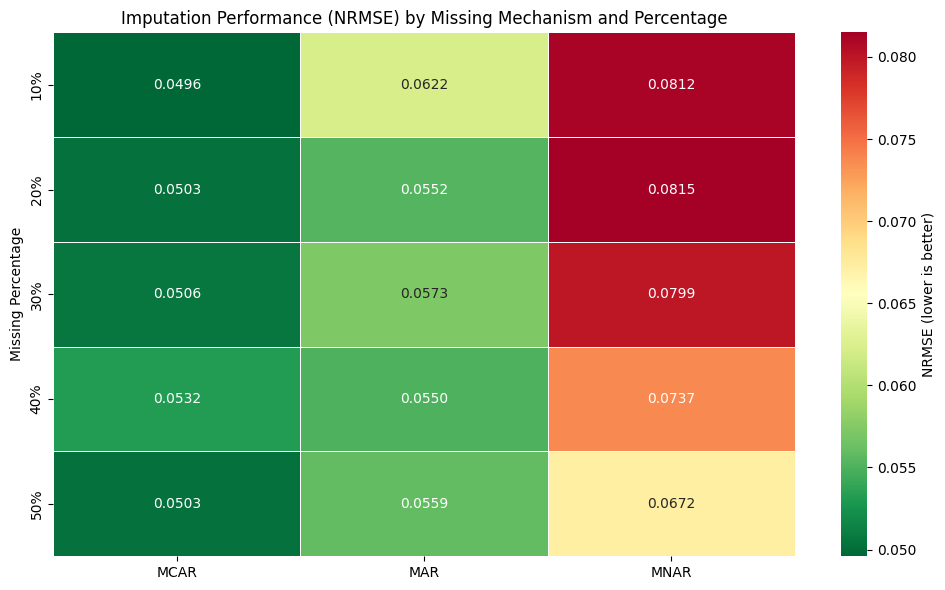

Line plot saved to models\2025-03-31_00-44-34_model\imputation_performance\imputation_performance_lineplot.png


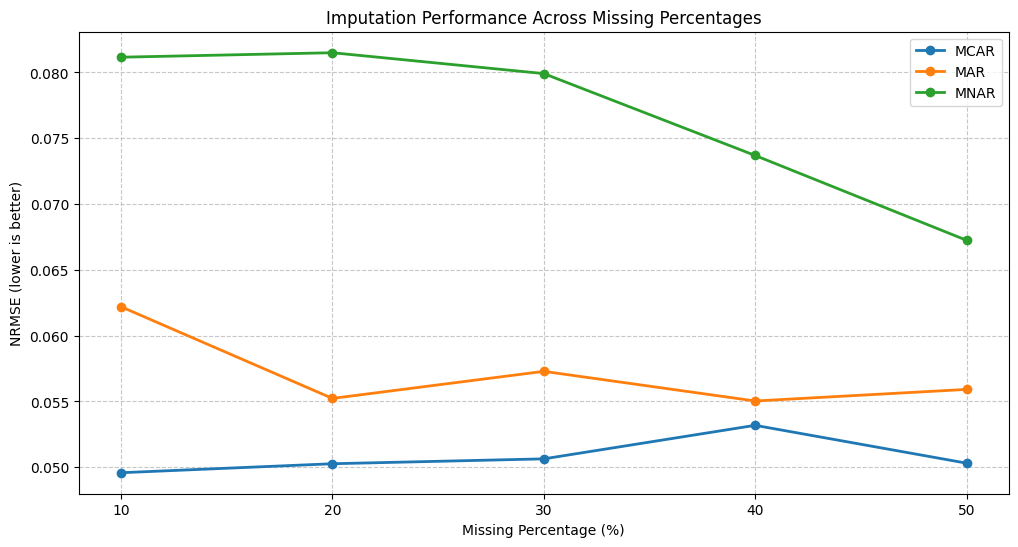

Bar chart saved to models\2025-03-31_00-44-34_model\imputation_performance\imputation_performance_barchart.png


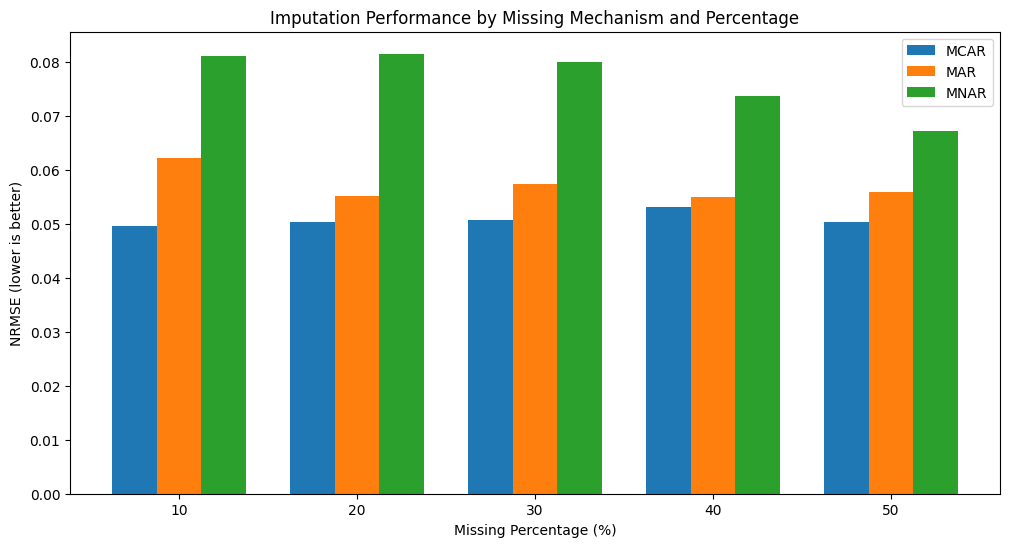

Table visualization saved to models\2025-03-31_00-44-34_model\imputation_performance\imputation_performance_table.png


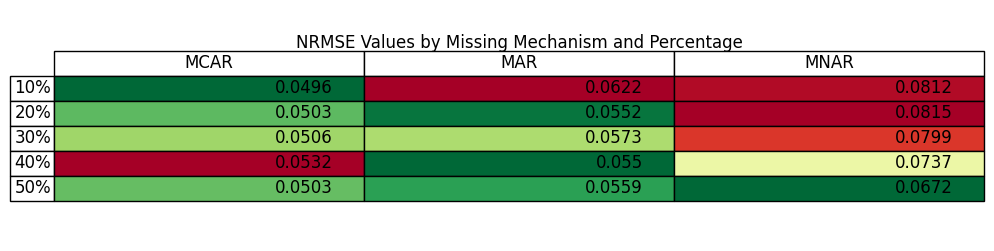


=== Evaluating MNAR Specialized Model Imputation Performance ===


Evaluating MNAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 23.51it/s]


MNAR at 10.0% missing: NRMSE = 0.0513


Evaluating MNAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 22.92it/s]


MNAR at 20.0% missing: NRMSE = 0.0588


Evaluating MNAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 23.33it/s]


MNAR at 30.0% missing: NRMSE = 0.0575


Evaluating MNAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 22.69it/s]


MNAR at 40.0% missing: NRMSE = 0.0640


Evaluating MNAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 18.40it/s]


MNAR at 50.0% missing: NRMSE = 0.0748
Raw MNAR specialized results saved to models\2025-03-31_00-44-34_model\imputation_performance\mnar_specialized_results.csv


<Figure size 1000x600 with 0 Axes>

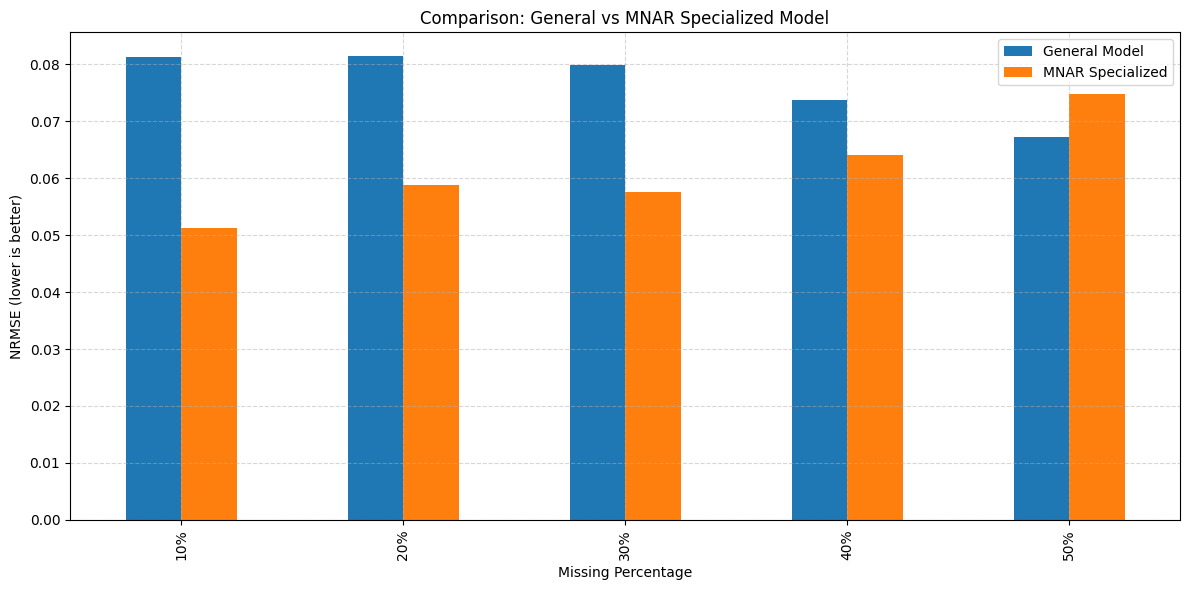


Imputation performance evaluation complete!


In [25]:
if __name__ == "__main__":
    # Import necessary libraries if they aren't already imported
    import seaborn as sns
    
    # Create a section for imputation performance evaluation
    print("\n=== Evaluating Imputation Performance Across Missing Percentages ===")
    
    # Define the missing percentages to evaluate
    missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Create a directory for imputation performance visualizations
    imputation_dir = os.path.join(save_dir, "imputation_performance")
    os.makedirs(imputation_dir, exist_ok=True)
    
    # Evaluate imputation performance
    results_df = evaluate_imputation_performance(
        model,                    # Use the final trained model
        test_data,                # Test data
        column_indices,           # Column indices
        missing_percentages,      # Missing percentages
        mechanisms                # Missing mechanisms
    )
    
    # Save the raw results to CSV
    results_csv_path = os.path.join(imputation_dir, "imputation_results.csv")
    results_df.to_csv(results_csv_path)
    print(f"Raw imputation results saved to {results_csv_path}")
    
    # Create and save visualizations
    visualize_imputation_performance(
        results_df,
        save_path=os.path.join(imputation_dir, "imputation_performance.png")
    )
    
    # If specialized MNAR model exists, evaluate it too
    if TRAIN_SPECIALIZED:
        print("\n=== Evaluating MNAR Specialized Model Imputation Performance ===")
        
        # Only evaluate the MNAR mechanism for the specialized model
        mnar_results_df = evaluate_imputation_performance(
            mnar_model,               # The specialized MNAR model
            test_data,                # Test data
            column_indices,           # Column indices
            missing_percentages,      # Missing percentages
            ["MNAR"]                  # Only MNAR mechanism
        )
        
        # Save the raw results to CSV
        mnar_results_csv_path = os.path.join(imputation_dir, "mnar_specialized_results.csv")
        mnar_results_df.to_csv(mnar_results_csv_path)
        print(f"Raw MNAR specialized results saved to {mnar_results_csv_path}")
        
        # Compare general vs specialized model for MNAR
        comparison_df = pd.DataFrame({
            "General Model": results_df["MNAR"],
            "MNAR Specialized": mnar_results_df["MNAR"]
        })
        
        # Create comparison visualizations
        plt.figure(figsize=(10, 6))
        comparison_df.plot(kind='bar', figsize=(12, 6))
        plt.title("Comparison: General vs MNAR Specialized Model")
        plt.xlabel("Missing Percentage")
        plt.ylabel("NRMSE (lower is better)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(imputation_dir, "mnar_model_comparison.png"))
        plt.show()
        
    print("\nImputation performance evaluation complete!")